## Домашнее задание
Построение модели логистической регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

Цель: В этом домашнем задании вы потренируетесь в настройке модели логистической регрессии, подборе коэффициента регуляризации и интерпретации результатов.
Снова про болезни, на этот раз про рак груди. Нужно научиться предсказывать, является ли клеточное образование злокачественным или нет.

1) Скачайте данные с Kaggle - https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv

2) Как всегда - базовые статистики, визуализации (распределения, корреляции, pair-plots). В тех графиках, которые это позволяют, раскрасьте значения в зависимости от того, является опухоль злокачественной или нет.

3) Как вы помните, логистическая регрессия плохо относится к линейно-зависимым признакам, во время предобработки, уберите переменные, корреляция пирсона между которыми превышает 0.85. Разбейте данные на train-test, отложив 30% выборки для тестирования. Приведите все непрерывные переменные к одному масштабу при помощи стандартизации.

4) Постройте модель логистической регрессии "из коробки" без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней. Визуализируйте влияние коэффициентов на целевую переменную.

5) Теперь проведите настройку параметра регуляризации C на кросс-валидации (LogisticRegressionCV). Снова оцените результаты и постройте визуализацию влияния коэффициентов на целевую переменную. Сделайте интересные выводы :)
__Бонусное задание__ - постройте также модель KNN с настройкой числа соседей на CV. У какой модели качество оказалось выше?

Критерии оценки: Максимум - 10 баллов.

За качественную предобработку и визуализации - 5 баллов, за настройку и визуализацию коэффициентов моделей - еще 5 баллов.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("breast_cancer.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
del df['Unnamed: 32']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000191E78E69B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000191E8A89320>]], dtype=object)

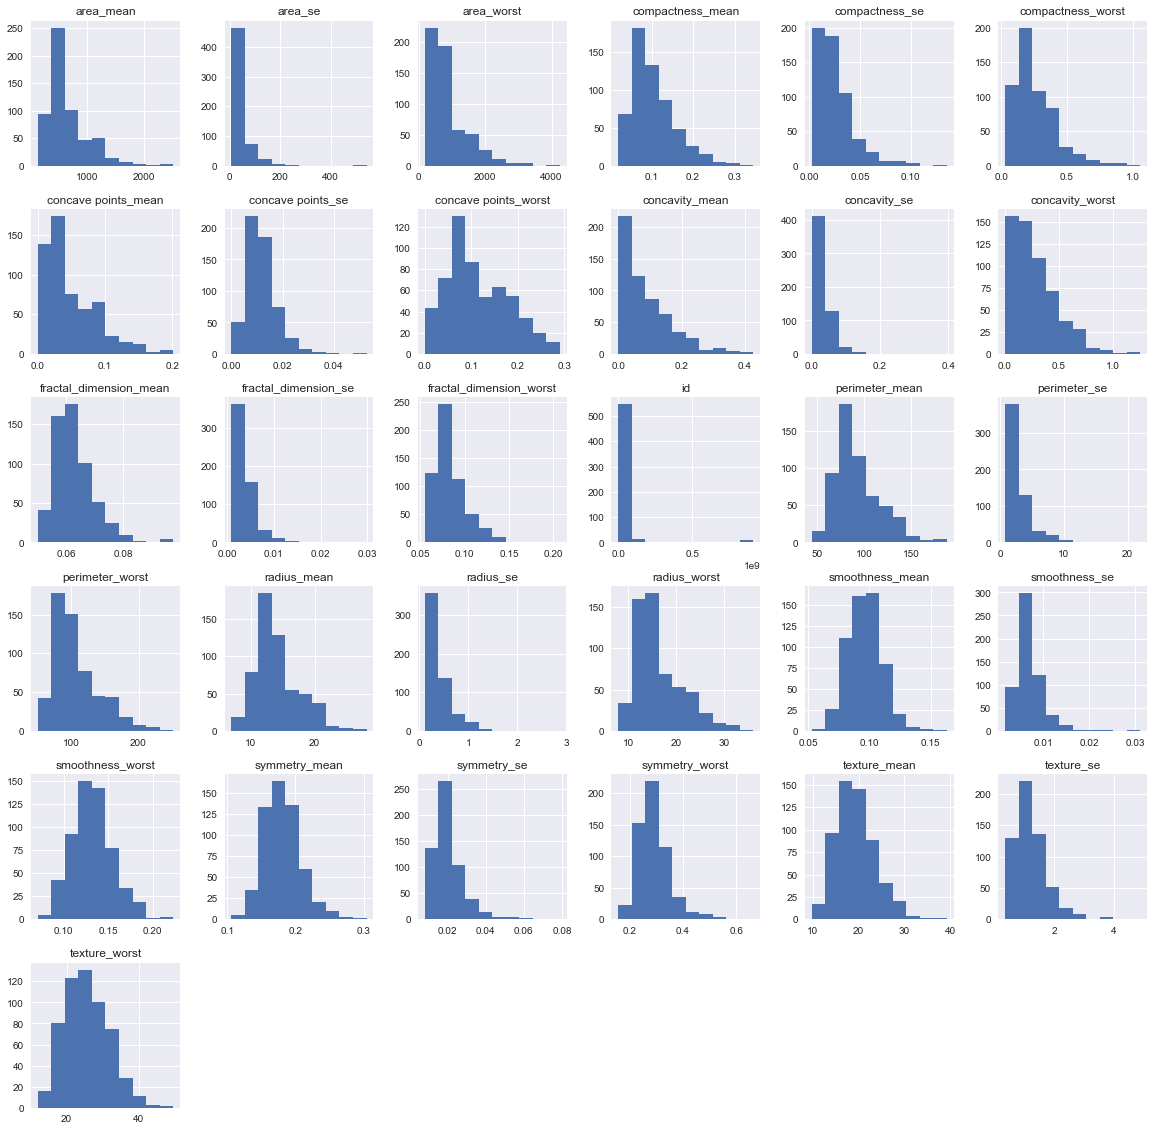

In [6]:
df.hist(figsize=(20,20))

In [7]:
df.replace(["B","M"],[0,1],inplace=True)

In [8]:
sns.pairplot(df[0:100], hue="diagnosis")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Сильная зависимость между переменными, которые выражаются друг через друга (например, радиус опухоли и все параметры, которые через него выражаются, такие как периметр и площадь опухоли). Не понятно почему радиус и плошадь с высокой корелляцией (вроде квадратичная зависимость, а не линейная).

In [9]:
Corr=df.corr(method='pearson')

In [10]:
CorField=[]
for k in Corr:
    for j in Corr.index[Corr[k] > 0.85]:
        if k != j and j not in CorField and k not in CorField:
            CorField.append(j)
            print (k, j, Corr[k][Corr.index == j].values[0])
#список переменных с корреляцией >0.85            
print(CorField)

radius_mean perimeter_mean 0.997855281494
radius_mean area_mean 0.987357170057
radius_mean radius_worst 0.969538972611
radius_mean perimeter_worst 0.965136513956
radius_mean area_worst 0.941082459586
texture_mean texture_worst 0.91204458884
compactness_mean concavity_mean 0.883120670177
compactness_mean compactness_worst 0.865809039802
concave points_mean concave points_worst 0.910155314299
radius_se perimeter_se 0.972793677016
radius_se area_se 0.951830112111
['perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'texture_worst', 'concavity_mean', 'compactness_worst', 'concave points_worst', 'perimeter_se', 'area_se']


In [11]:
#Удалим переменные с большой корреляцией с другими признаками
df=df.drop(CorField,axis=1)

In [12]:
df.head()

,id,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,...,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,0.11840,0.27760,0.14710,0.2419,0.07871,1.0950,...,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.7119,0.4601,0.11890
1,842517,1,20.57,17.77,0.08474,0.07864,0.07017,0.1812,0.05667,0.5435,...,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.2416,0.2750,0.08902
2,84300903,1,19.69,21.25,0.10960,0.15990,0.12790,0.2069,0.05999,0.7456,...,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4504,0.3613,0.08758
3,84348301,1,11.42,20.38,0.14250,0.28390,0.10520,0.2597,0.09744,0.4956,...,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.6869,0.6638,0.17300
4,84358402,1,20.29,14.34,0.10030,0.13280,0.10430,0.1809,0.05883,0.7572,...,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.4000,0.2364,0.07678


In [13]:
#sns.pairplot(df[0:100], hue="diagnosis")

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [15]:
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['diagnosis'], axis=1), 
    df['diagnosis'], 
    test_size=0.30, 
    random_state=42, 
    stratify=df['diagnosis']
)

# стандартизируем
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg.predict(X_train_scaled), y_train)
print("\n Test quality:")
quality_report(log_reg.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.987
Precision: 0.966
Recall: 1.000
f1_score: 0.983

 Test quality:
Accuracy: 0.977
Precision: 0.938
Recall: 1.000
f1_score: 0.968


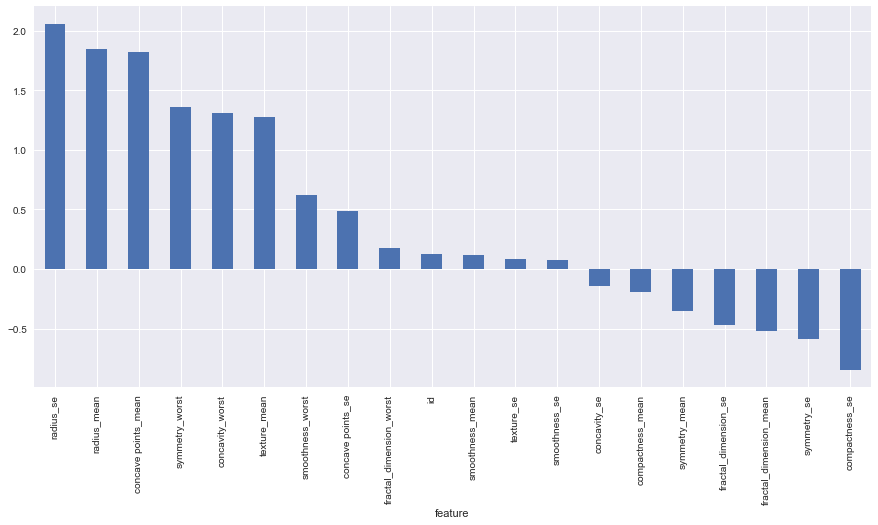

In [18]:
featureImportance = pd.DataFrame({"feature": df.drop('diagnosis',axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 7));

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    print("AUC_ score=", auc_score)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

AUC_ score= 0.996933411215


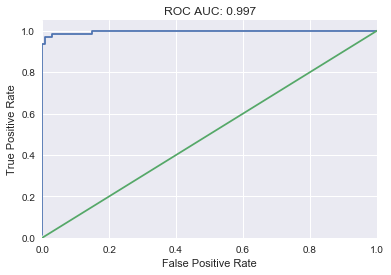

In [20]:
plot_roc_curve(log_reg.predict_proba(X_test_scaled)[:,1], y_test)

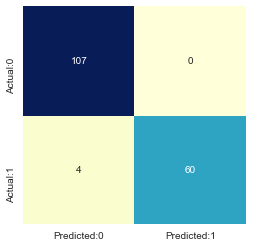

In [22]:
from sklearn.metrics import confusion_matrix

#

cm = confusion_matrix(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]>0.5)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (4,4))

sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

## Настройка параметра регуляризации C на кросс-валидации

In [23]:
log_reg_cv = LogisticRegressionCV(Cs=100)
log_reg_cv.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg_cv.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg_cv.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.985
Precision: 0.959
Recall: 1.000
f1_score: 0.979

Test quality:
Accuracy: 0.977
Precision: 0.938
Recall: 1.000
f1_score: 0.968


AUC_ score= 0.998247663551


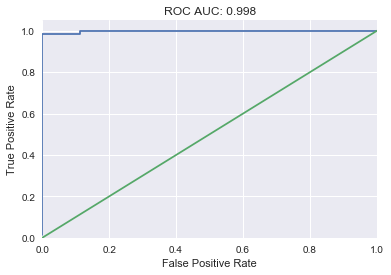

In [24]:
plot_roc_curve(log_reg_cv.predict_proba(X_test_scaled)[:,1], y_test)

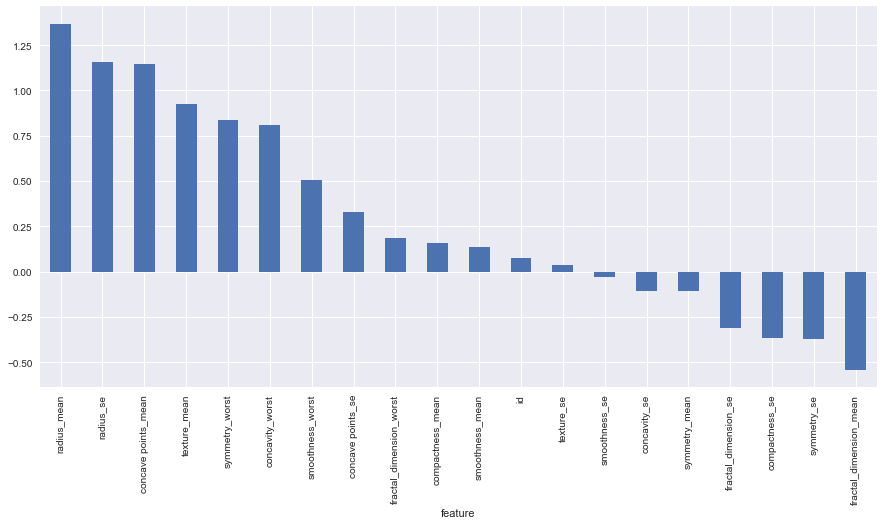

In [25]:
featureImportance = pd.DataFrame({"feature": df.drop('diagnosis',axis=1).columns, 
                                  "importance": log_reg_cv.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 7));

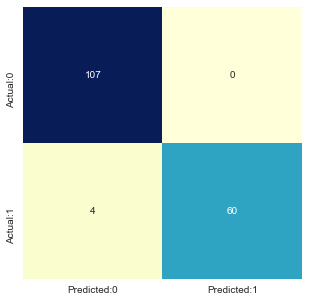

In [27]:
#from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, log_reg_cv.predict_proba(X_test_scaled)[:, 1]>0.5)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

В нашем случае кросс-валидация на дала большого выигрыша. Странно, что id дает вклад (хоть и не большой)